In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/GL4_private/Big data/F1 Dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/GL4_private/Big data/F1 Dataset/test.csv')
sample_sub = pd.read_csv('/content/drive/MyDrive/GL4_private/Big data/F1 Dataset/sample_submission.csv')

# Check for missing values
print("Train missing values:")
print(train_df.isnull().sum())
print("\nTest missing values:")
print(test_df.isnull().sum())



Train missing values:
id                         0
race                       0
date                       0
time                    7035
circuit                    0
latitude                   0
longitude                  0
altitude                   0
driver                     0
carNumber                  0
constructor                0
avgDriverFinish            0
avgConstructorFinish       0
lapNumber                  0
lapPosition                0
pitStop                    0
pitCount                   0
pitTime_ms                 0
lapTime_ms                 0
dtype: int64

Test missing values:
id                         0
race                       0
date                       0
time                    4837
circuit                    0
latitude                   0
longitude                  0
altitude                   0
driver                     0
carNumber                  0
constructor                0
avgDriverFinish            0
avgConstructorFinish       0
lapNumber      

In [ ]:
train_df.drop(columns=['time'], inplace=True, errors='ignore')
test_df.drop(columns=['time'], inplace=True, errors='ignore' )

train_df.drop(columns=['date'], inplace=True, errors='ignore')
test_df.drop(columns=['date'], inplace=True, errors='ignore' )

# 2. Convert categorical variables
categorical_cols = ['race', 'circuit', 'driver', 'constructor']
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# 3. Verify no missing values remain
print("Remaining missing values in train:", train_df.isnull().sum().sum())
print("Remaining missing values in test:", test_df.isnull().sum().sum())

# 4. Separate features and target (if not already done)
X_train = train_df.drop('lapTime_ms', axis=1)
y_train = train_df['lapTime_ms']
X_test = test_df
y_test = sample_sub['lapTime_ms']

Remaining missing values in train: 0
Remaining missing values in test: 0


XGboost

[0]	validation_0-rmse:679.00760
[10]	validation_0-rmse:5946.37651
[20]	validation_0-rmse:10609.58192
[30]	validation_0-rmse:15554.38573
[40]	validation_0-rmse:19312.08836
[49]	validation_0-rmse:21443.76236
XGBoost MAE: 136.40, RMSE: 679.01


<Figure size 1000x800 with 0 Axes>

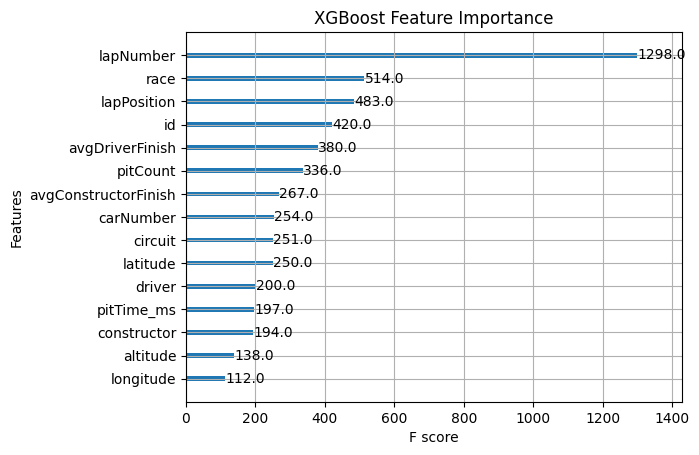

In [ ]:
# XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Evaluate performance
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"XGBoost MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")

# Feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
#Save model to pickle file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'xgb_laptime_model_{timestamp}.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(xgb_model, file)

print(f"\nModel saved as {model_filename}")

LSTM

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM [samples, timesteps, features]
# Since we don't have natural sequences, we'll create artificial ones by grouping laps
# Here we'll use a window of 5 consecutive laps to predict the next lap time

def create_sequences(data, targets, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(targets[i+window_size])
    return np.array(X), np.array(y)

window_size = 5
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, window_size)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Training sequences shape: (29995, 5, 16)
Test sequences shape: (20709, 5, 16)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 13546398720.0000 - mae: 94630.5781 - val_loss: 8818761728.0000 - val_mae: 93908.0078
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 13137654784.0000 - mae: 93683.5547 - val_loss: 8526521344.0000 - val_mae: 92339.5703
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 11863634944.0000 - mae: 91480.5312 - val_loss: 8076684288.0000 - val_mae: 89870.4297
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 12308338688.0000 - mae: 89342.6484 - val_loss: 7515833856.0000 - val_mae: 86693.9844
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 11641334784.0000 - mae: 86009.7031 - val_loss: 6875482112.0000 - val_mae: 82918.1484
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 10101323776.0000 - mae: 81644.8672 - val_loss: 6181084672.0000 - val_mae: 78619.9531
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 10158269440.0000 - mae: 77474.5234 - val_loss: 545950873

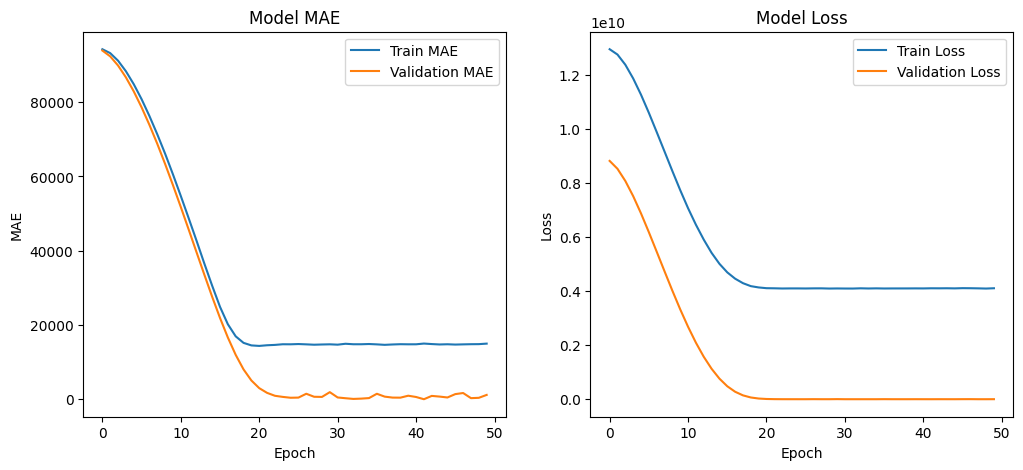

In [ ]:
# LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train the model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

# Make predictions
lstm_pred = lstm_model.predict(X_test_seq).flatten()

# Evaluate performance
lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred))
print(f"LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Model Comparison:
     Model          MAE         RMSE
0  XGBoost   136.400163   679.007632
1     LSTM  1166.236369  1166.244170


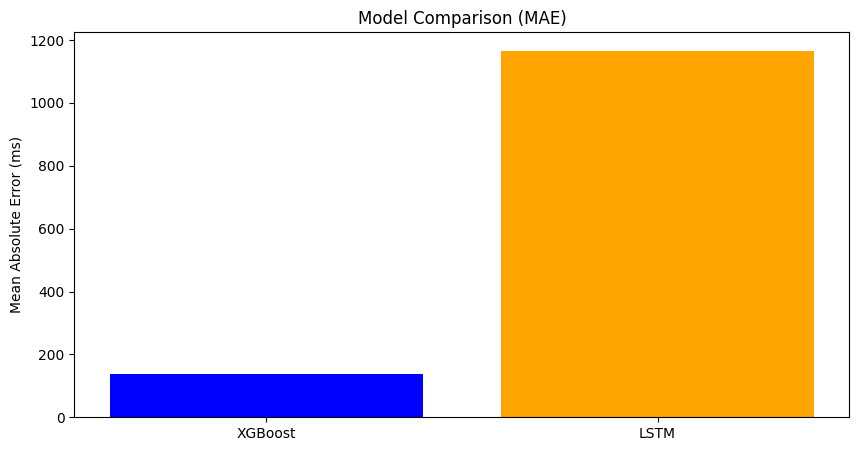

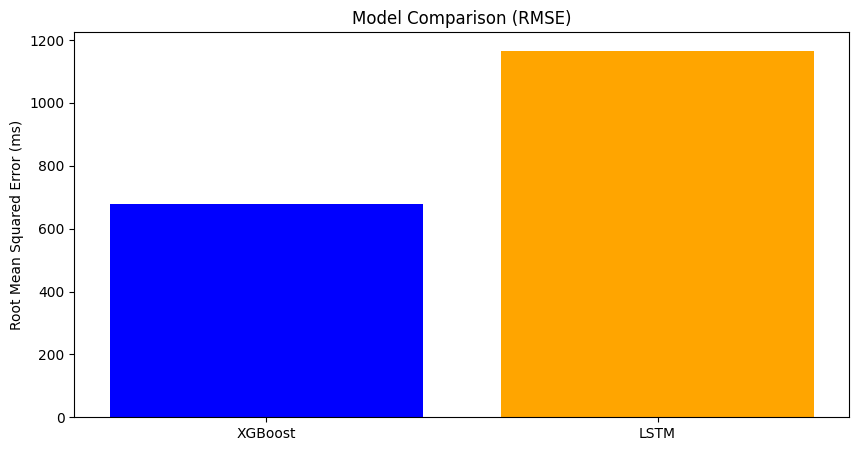

In [ ]:
# Compare model performance
results = pd.DataFrame({
    'Model': ['XGBoost', 'LSTM'],
    'MAE': [xgb_mae, lstm_mae],
    'RMSE': [xgb_rmse, lstm_rmse]
})

print("\nModel Comparison:")
print(results)

# Plot comparison
plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['MAE'], color=['blue', 'orange'])
plt.title('Model Comparison (MAE)')
plt.ylabel('Mean Absolute Error (ms)')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(results['Model'], results['RMSE'], color=['blue', 'orange'])
plt.title('Model Comparison (RMSE)')
plt.ylabel('Root Mean Squared Error (ms)')
plt.show()

Use greedy search to optimize xgboost params

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Base parameters
base_params = {
    'objective': 'reg:squarederror',
    'random_state': 42,
    'n_estimators': 1000,
    'early_stopping_rounds': 50
}

# Parameter search space
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Greedy search implementation
def greedy_param_search(X_train, y_train, X_test, y_test, base_params, param_grid, n_iter=20):
    best_params = base_params.copy()
    best_rmse = float('inf')
    history = []

    # Initial evaluation
    model = xgb.XGBRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    current_rmse = np.sqrt(mean_squared_error(y_test, preds))
    history.append((best_params.copy(), current_rmse))

    for _ in range(n_iter):
        improved = False

        # Search each parameter sequentially
        for param in param_grid:
            for value in param_grid[param]:
                test_params = best_params.copy()
                test_params[param] = value

                model = xgb.XGBRegressor(**test_params)
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
                preds = model.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, preds))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params[param] = value
                    improved = True
                    history.append((best_params.copy(), best_rmse))
                    print(f"Improvement! {param}={value}, RMSE: {best_rmse:.4f}")

        if not improved:
            print("No improvement found - stopping early")
            break

    return best_params, best_rmse, history

# Run greedy search
best_params, best_rmse, history = greedy_param_search(
    X_train, y_train, X_test, y_test, base_params, param_grid
)

print("\nBest parameters found:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")

# Train final model with best parameters
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=10
)

# Evaluate final model
final_pred = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))
print(f"\nFinal model RMSE: {final_rmse:.4f}")


Improvement! learning_rate=0.001, RMSE: 61.3342
Improvement! max_depth=3, RMSE: 34.0676
Improvement! subsample=0.6, RMSE: 30.4483
Improvement! colsample_bytree=0.6, RMSE: 30.0162
Improvement! subsample=0.7, RMSE: 27.8330
Improvement! subsample=0.8, RMSE: 26.3570
Improvement! min_child_weight=3, RMSE: 26.1063
No improvement found - stopping early

Best parameters found:
{'objective': 'reg:squarederror', 'random_state': 42, 'n_estimators': 1000, 'early_stopping_rounds': 50, 'learning_rate': 0.001, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 3}
Best RMSE: 26.1063
[0]	validation_0-rmse:26.10635
[10]	validation_0-rmse:216.84898
[20]	validation_0-rmse:439.05610
[30]	validation_0-rmse:717.34996
[40]	validation_0-rmse:898.83380
[49]	validation_0-rmse:1135.63008

Final model RMSE: 26.1063


In [ ]:
# Save the optimized model
import pickle
pickle.dump(final_model, open('optimized_xgb_model.pkl', 'wb'))

Altitude Extraction

In [ ]:
set(map(tuple, train_df[['circuit', 'altitude']].values))

{('Albert Park Grand Prix Circuit', 10),
 ('Autodromo Nazionale di Monza', 162),
 ('Autódromo Hermanos Rodríguez', 2227),
 ('Autódromo Internacional do Algarve', 108),
 ('Autódromo José Carlos Pace', 785),
 ('Bahrain International Circuit', 7),
 ('Baku City Circuit', -7),
 ('Circuit Gilles Villeneuve', 13),
 ('Circuit Park Zandvoort', 6),
 ('Circuit de Monaco', 7),
 ('Circuit de Nevers Magny-Cours', 228),
 ('Circuit de Spa-Francorchamps', 401),
 ('Circuit of the Americas', 161),
 ('Fuji Speedway', 583),
 ('Hungaroring', 264),
 ('Indianapolis Motor Speedway', 223),
 ('Istanbul Park', 130),
 ('Nürburgring', 578),
 ('Red Bull Ring', 678),
 ('Sepang International Circuit', 18),
 ('Shanghai International Circuit', 5),
 ('Silverstone Circuit', 153),
 ('Suzuka Circuit', 45),
 ('Yas Marina Circuit', 3)}